In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import poisson
import copy

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

In [3]:
# gloabal constants
N = 1000000  # size of simulated population
DT = 0.1  # time step
STATUS_VALUE = {
    'E': 0, # exposed, not infected yet
    'A0': 1, # early asymptomatic, not infectious
    'A1': 2, # late asymptomatic, infectious
    'S': 3, # asymptomatic, infectious
    'H': 4, # hospitalized
    'R': 5, # recovered or dead
}

# characteristics of each individual
TAU_A0 = poisson.rvs(2, size=N)  # dwelling time for A0 state
TAU_A1 = poisson.rvs(4, size=N)  # dwelling time for A1 state
TAU_H = poisson.rvs(14, size=N)  # dwelling time for H state

A0_TO_R = np.random.rand(N) < 0.1 # probability from A0 to R
A0_TO_A1 = ~A0_TO_R # probability from A0 to A1
A1_TO_R = np.random.rand(N) < 0.2 # probability from A1 to R
A1_TO_S = ~A1_TO_R  # probability from A0 to S
S_TO_R = np.random.rand(N) < 0.3 # probability from S to R
S_TO_H = ~S_TO_R # probability from S to H

In [4]:
def get_population(status):
    """
    Get size and detailed indices of each population.
    Args:
        status (1d array of int): The first parameter.
    Returns:
        population (dict): size of each population.
        indices (dict): indices of each population.
    """
    population = {}
    indices = {}
    for k,v in STATUS_VALUE.items():
        res = np.where(status == v)[0]
        population[k] = res.size
        indices[k] = res
    return population, indices

In [5]:
def init(size_total=100, size_A0=10, size_A1=0, size_S=0):
    """
    Initialize status, dwell_time and count.
    """
    status = np.ones(size_total) * STATUS_VALUE['E']
    dwell_time = np.zeros(size_total)
    # infection source
    status[:size_A0] = STATUS_VALUE['A0']
    status[size_A0:size_A0+size_A1] = STATUS_VALUE['A1']
    status[size_A0+size_A1:size_A0+size_A1+size_S] = STATUS_VALUE['S']
    count = {c: [] for c in STATUS_VALUE.keys()}
    count['daily S'] = []
    return status, dwell_time, count

In [6]:
def evolve(
    status, dwell_time, count, 
    days=10,
    dt=0.1,
    tau_S_start=4,
    tau_S_end=4, 
    beta_A1=0.3, 
    beta_S=0.3, 
):
    status = np.array(status)
    dwell_time = np.array(dwell_time)
    count = copy.deepcopy(count)
    nt = int(1/dt)
    for t in range(days):
        daily_S = 0
        tau_S = tau_S_start + (tau_S_end - tau_S_start) * t / days
        for tt in range(nt):
            population, indices = get_population(status)
            if tt == 0:
                for k,v in population.items():
                    count[k].append(int(v))
            # E -> A0
            nb_E_to_A0 = round((
                    beta_A1*population['E']*population['A1']/N + 
                    beta_S*population['E']*population['S']/N
                ) * dt)
            nb_E_to_A0 = min(nb_E_to_A0, population['E'])
            if nb_E_to_A0 > 0:
                idx_E_to_A0 = indices['E'][:nb_E_to_A0]
            else:
                idx_E_to_A0 = []
            # A0 -> R, A1
            idx_A0_end = indices['A0'][
                np.where(dwell_time[indices['A0']] >= TAU_A0[indices['A0']])[0]
            ]
            if idx_A0_end.size > 0:
                idx_A0_to_R = idx_A0_end[np.where(A0_TO_R[idx_A0_end])[0]]
                idx_A0_to_A1 = idx_A0_end[np.where(A0_TO_A1[idx_A0_end])[0]]
            else:
                idx_A0_to_R, idx_A0_to_A1 = [], []
            # A1 -> R, S
            idx_A1_end = indices['A1'][
                np.where(dwell_time[indices['A1']] >= TAU_A1[indices['A1']])[0]
            ]
            if idx_A1_end.size > 0:
                idx_A1_to_R = idx_A1_end[np.where(A1_TO_R[idx_A1_end])[0]]
                idx_A1_to_S = idx_A1_end[np.where(A1_TO_S[idx_A1_end])[0]]
            else:
                idx_A1_to_R, idx_A1_to_S = [], []
            # S -> R, H
            idx_S_end = indices['S'][
                np.where(dwell_time[indices['S']] >= tau_S)[0]
            ]
            if idx_S_end.size > 0:
                idx_S_to_R = idx_S_end[np.where(S_TO_R[idx_S_end])[0]]
                idx_S_to_H = idx_S_end[np.where(S_TO_H[idx_S_end])[0]]
            else:
                idx_S_to_R, idx_S_to_H = [], []
            # H -> R
            idx_H_to_R = indices['H'][
                np.where(dwell_time[indices['H']] >= TAU_H[indices['H']])[0]
            ]
            # update status
            status[idx_E_to_A0] = STATUS_VALUE['A0']
            status[idx_A0_to_R] = STATUS_VALUE['R']
            status[idx_A0_to_A1] = STATUS_VALUE['A1']
            status[idx_A1_to_R] = STATUS_VALUE['R']
            status[idx_A1_to_S] = STATUS_VALUE['S']
            status[idx_S_to_R] = STATUS_VALUE['R']
            status[idx_S_to_H] = STATUS_VALUE['H']
            status[idx_H_to_R] = STATUS_VALUE['R']
            # update dwell time
            dwell_time[idx_E_to_A0] = 0
            dwell_time[idx_A0_to_R] = 0
            dwell_time[idx_A0_to_A1] = 0
            dwell_time[idx_A1_to_R] = 0
            dwell_time[idx_A1_to_S] = 0
            dwell_time[idx_S_to_R] = 0
            dwell_time[idx_S_to_H] = 0
            dwell_time[idx_H_to_R] = 0
            dwell_time += dt
            daily_S += len(idx_A1_to_S)
        count['daily S'].append(daily_S)
    return status, dwell_time, count

In [7]:
# read wuhan data
df = pd.read_csv('../data/wuhan.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.resample('1D').bfill()
df = df.iloc[48:]
wuhan_data = df['confirmed'].diff().fillna(0).to_numpy()

In [8]:
# initilization
res_init = init(size_total=N, size_A0=100, size_A1=20, size_S=10)

# stage1
T1=30
beta_A1 = 0.4
beta_S = 0.4
tau_S_start = 4
tau_S_end = 4
res_stage1 = evolve(
    *res_init, 
    dt=DT, days=T1, tau_S_start=tau_S_start, tau_S_end=tau_S_end, beta_A1=beta_A1, beta_S=beta_S
)

# stage2
T2 = 6
beta_A1 = 0.2
beta_S = 0.2
tau_S_start = 4
tau_S_end = 0
res_stage2 = evolve(
    *res_stage1,
    dt=DT, days=T2, tau_S_start=tau_S_start, tau_S_end=tau_S_end, beta_A1=beta_A1, beta_S=beta_S
)

# stage3
T3=40
beta_A1 = 0.1
beta_S = 0.1
tau_S_start = 0
tau_S_end = 0
res_stage3 = evolve(
    *res_stage2,
    dt=DT, days=T3, tau_S_start=tau_S_start, tau_S_end=tau_S_end, beta_A1=beta_A1, beta_S=beta_S
)

(10, 3000)

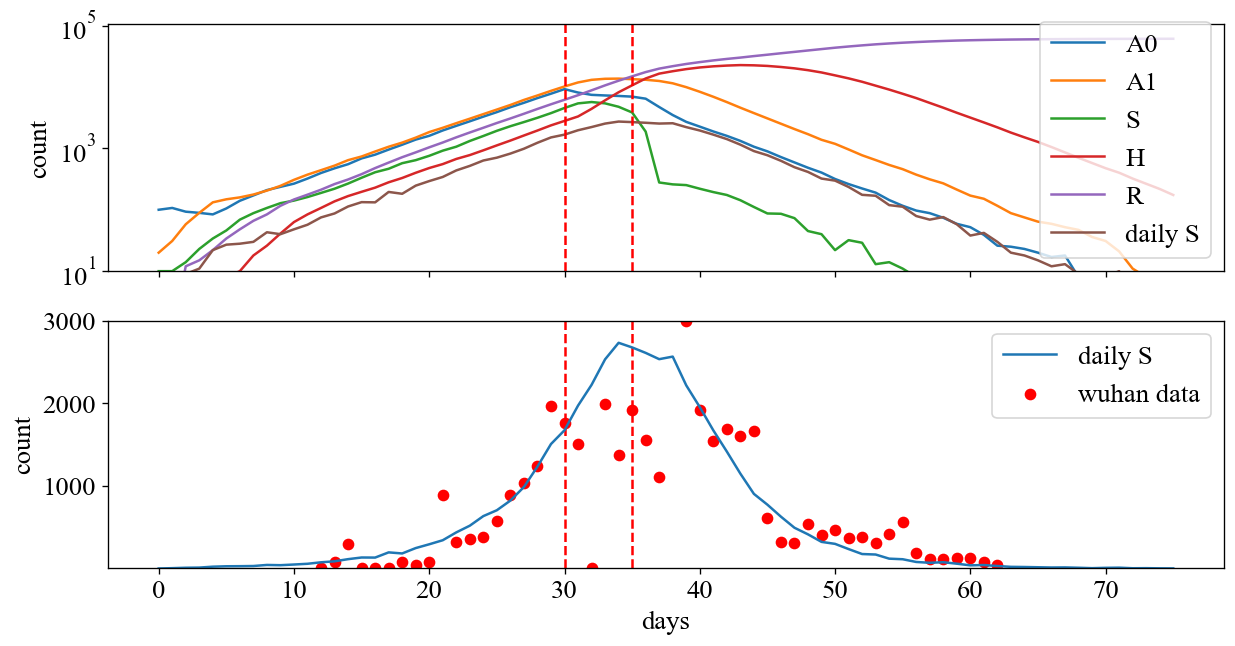

In [9]:
fig, ax = plt.subplots(figsize=(12, 6), nrows=2, dpi=120, sharex=True)
for k,v in res_stage3[2].items():
    if k in ('E', ):
        continue
    ax[0].semilogy(v, label=k)
ax[0].set_ylim(ymin=10)
ax[0].legend()
ax[0].set_ylabel('count')
for x in (30, 35):
    ax[0].axvline(x=x, color='red', linestyle='--')
    ax[1].axvline(x=x, color='red', linestyle='--')

ax[1].plot(res_stage3[2]['daily S'], label='daily S')
ax[1].scatter(np.arange(wuhan_data.size)+12, wuhan_data, color='red', label='wuhan data')
ax[1].legend()
ax[1].set_ylabel('count')
ax[1].set_xlabel('days')
ax[1].set_ylim([10, 3000])